## Rental Bike Management

1. We will first explore the dataset provided
2. We will create models to predict the hourly bike rental demand. 
3. We will also make predictions for hourly demand in the test set which you can submit in the solution_checker.xlsx file to generate rmsle score.

In [12]:
# importing libraries
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
import calendar
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

In [13]:
# loadind the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [14]:
# shape of training and testing data
train.shape, test.shape

((12980, 12), (4399, 11))

In [15]:
# printing first five rows
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 0:00:00,1,0,0,1,9.84,14.395,81.0,0.0,3,13,16
1,2011-01-01 1:00:00,1,0,0,1,9.02,13.635,80.0,0.0,8,32,40
2,2011-01-01 2:00:00,1,0,0,1,9.02,13.635,80.0,0.0,5,27,32
3,2011-01-01 3:00:00,1,0,0,1,9.84,14.395,75.0,0.0,3,10,13
4,2011-01-01 4:00:00,1,0,0,1,9.84,14.395,75.0,0.0,0,1,1


In [16]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered
0,2012-06-30 1:00:00,3,0,0,3,26.24,28.790,89.0,15.0013,3,55
1,2012-06-30 2:00:00,3,0,0,2,26.24,28.790,89.0,0.0000,7,54
2,2012-06-30 3:00:00,3,0,0,2,26.24,28.790,89.0,0.0000,3,20
3,2012-06-30 4:00:00,3,0,0,2,25.42,27.275,94.0,0.0000,3,15
4,2012-06-30 5:00:00,3,0,0,1,26.24,28.790,89.0,11.0014,3,7


In [17]:
# columns in the dataset
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [18]:
test.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered'],
      dtype='object')

In [19]:
# Data type of the columns
train.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity      float64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

## Univariate Analysis

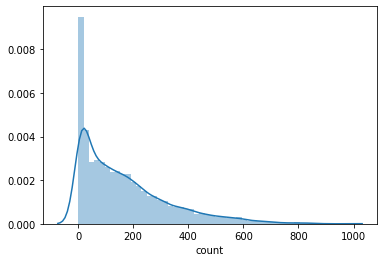

In [20]:
# distribution of count variable
sn.distplot(train["count"])

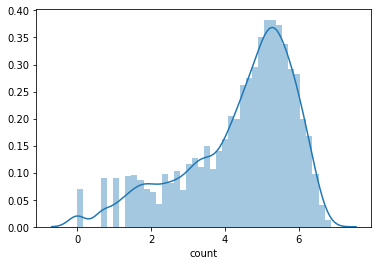

In [21]:
sn.distplot(np.log(train["count"]))

Now the distribution looks less skewed. Let's now explore the variables to have a better understanding of the dataset. We will first explore the variables individually using univariate analysis, then we will look at the relation between various independent variables and the target variable. We will also look at the correlation plot to see which variables affects the target variable most.

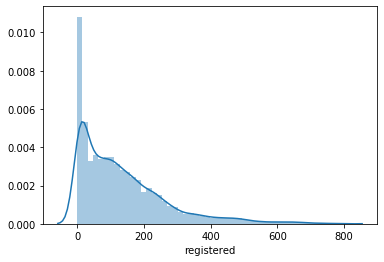

In [22]:
sn.distplot(train["registered"])

We can see that most of the registered rentals lies in the range of 0 to 200. The registered users at a particular time step will always be less than or equal to the demand (count) of that particular timestep. 

Let's now look at how correlated our numerical variables are. 

We will see the correlation between each of these variables and the variable which have high negative or positive values are correlated. By this we can get an overview of the variables which might affect our target variable.

## Bivariate Analysis

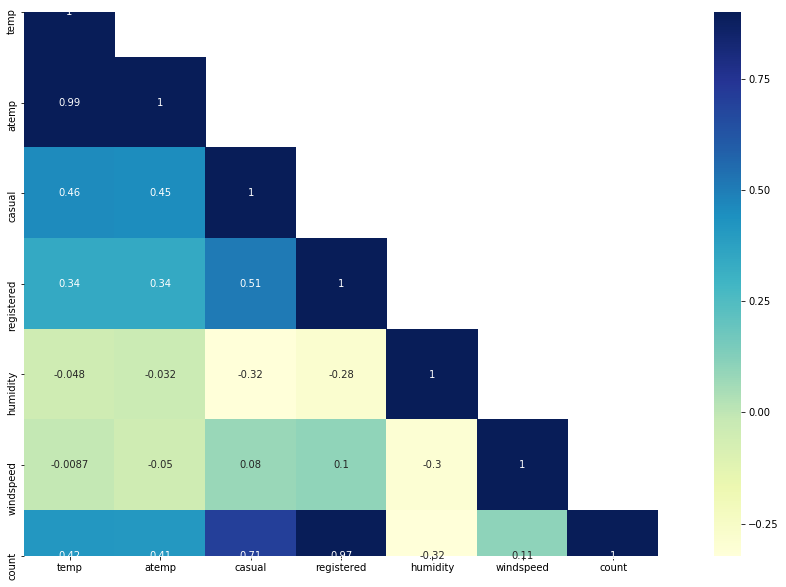

In [23]:
# looking at the correlation between numerical variables
corr = train[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corr, mask=mask,vmax=.9, square=True,annot=True, cmap="YlGnBu")

Some of the inferences from the above correlation map are:

1. temp and humidity features has got positive and negative correlation with count respectively.Although the correlation between them are not very prominent still the count variable has got little dependency on "temp" and "humidity".

2. windspeed will not be really useful numerical feature and it is visible from it correlation value with "count"

3. Since "atemp" and "temp" has got strong correlation with each other, during model building any one of the variable has to be dropped since they will exhibit multicollinearity in the data.

In [24]:
# looking for missing values in the datasaet
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

### There are no missing values in the train dataset

In [25]:
test.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
dtype: int64

In [26]:
# extracting date, hour and month from the datetime
train["date"] = train.datetime.apply(lambda x : x.split()[0])
train["hour"] = train.datetime.apply(lambda x : x.split()[1].split(":")[0])
train["month"] = train.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

Let's now build a linear regression model to get the predictions on the test data. We have to make the similar changes in test data as we have done for the training data.

In [27]:
test["date"] = test.datetime.apply(lambda x : x.split()[0])
test["hour"] = test.datetime.apply(lambda x : x.split()[1].split(":")[0])
test["month"] = test.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

In [28]:
training = train[train['datetime']<='2012-03-30 0:00:00']
validation = train[train['datetime']>'2012-03-30 0:00:00']

* We will drop the datetime, date variable as we have already extracted features from these variables.
* We will also drop the atemp variable as we saw that it is highly correlated with the temp variable.

In [29]:
train = train.drop(['datetime','date', 'atemp'],axis=1)
test = test.drop(['datetime','date', 'atemp'], axis=1)
training = training.drop(['datetime','date', 'atemp'],axis=1)
validation = validation.drop(['datetime','date', 'atemp'],axis=1)

## Model Building
### Linear Regression Model

In [30]:
from sklearn.linear_model import LinearRegression

In [31]:
# initialize the linear regression model
lModel = LinearRegression()

In [32]:
X_train = training.drop('count', 1)
y_train = np.log(training['count'])
X_val = validation.drop('count', 1)
y_val = np.log(validation['count'])

In [33]:
# checking the shape of X_train, y_train, X_val and y_val
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((10774, 11), (10774,), (2206, 11), (2206,))

In [34]:
# fitting the model on X_train and y_train
lModel.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Now we have a trained linear regression model with us. We will now make prediction on the X_val set and check the performance of our model. Since the evaluation metric for this problem is RMSLE, we will define a model which will return the RMSLE score.

In [35]:
# making prediction on validation set
prediction = lModel.predict(X_val)

In [36]:
# defining a function which will return the rmsle score
def rmsle(y, y_):
    y = np.exp(y),   # taking the exponential as we took the log of target variable
    y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

Let's now calculate the rmsle value of the predictions

In [37]:
rmsle(y_val,prediction)

0.8875379204281793

We got a rmsle value of 0.8875 on the validation set.

Let's use Decision Tree now. Note that rmsle tells us how far the predictions are from the actual value, so we want rmsle value to be as close to 0 as possible. So, we will further try to reduce this value.

## Decision Tree

In [38]:
from sklearn.tree import DecisionTreeRegressor

In [39]:
# defining a decision tree model with a depth of 5. You can further tune the hyperparameters to improve the score
dt_reg = DecisionTreeRegressor(max_depth=5)

In [40]:
dt_reg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [41]:
predict = dt_reg.predict(X_val)

In [42]:
# calculating rmsle of the predicted values
rmsle(y_val, predict)

0.17102267399446988

The rmsle value has decreased to 0.171. This is a decent score. Let's now make predictions for the test dataset which you can submit in the excel sheet provided to you to generate your score.

In [43]:
test_prediction = dt_reg.predict(test)

In [44]:
final_prediction = np.exp(test_prediction)

Finally, we will save these predictions into a csv file. You can then open this csv file and copy paste the predictions on the provided excel file to generate score.

In [45]:
submission = pd.DataFrame()

In [46]:
# creating a count column and saving the predictions in it
submission['count'] = final_prediction

In [47]:
submission.to_csv('submission.csv', header=True, index=False)